# Transfer Learning

[Transfer learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a) is a powerful technique that allows sophisticated convolutional neural networks (CNNs) trained by Google, Microsoft, and others on GPUs to be repurposed and used to solve domain-specific problems. With transfer learning, for example, you can take a CNN trained to distinguish between dogs and cats and modify it to distinguish between hot dogs and hambugers. And you can do it on a typical PC or laptop computer — no GPU required.

Many pretrained CNNs are available in the public domain, and several are included with Keras. In this exercise, you will use Keras and Microsoft's [ResNet-50V2](https://keras.io/api/applications/resnet/#resnet50v2-function) pretrained CNN to build a network that distinguishes with a high degree of accuracy between images containing Arctic foxes, polar bears, and walruses.

![](Images/wildlife.png)

## Load training and testing images

The first step is to load the images that will be used for training and testing and to label the images with 0 for Arctic foxes, 1 for polar bears, and 2 for walruses. We'll start by defining a function for loading images from the file system and affixing labels to them, and another function for displaying images. We will also define four Python lists to hold the images used for training and testing (`x_train` and `x_test`) and the labels used for training and testing (`y_train` and `y_test`).

In [1]:
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

def load_images_from_path(path, label):
    images, labels = [], []
 
    for file in os.listdir(path):
        img = image.load_img(os.path.join(path, file), target_size=(224, 224, 3))
        images.append(image.img_to_array(img))
        labels.append((label))
         
    return images, labels
 
def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20),
                             subplot_kw={'xticks': [], 'yticks': []})
 
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)
 
x_train, y_train, x_test, y_test = [], [], [], []

Load Arctic-fox training images and show the first few.

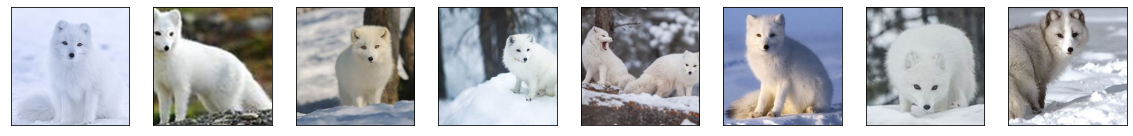

In [2]:
images, labels = load_images_from_path('Wildlife/train/arctic_fox', 0)
show_images(images)
    
x_train += images
y_train += labels

Load polar-bear training images.

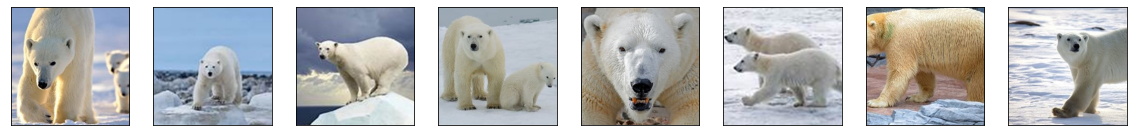

In [3]:
images, labels = load_images_from_path('Wildlife/train/polar_bear', 1)
show_images(images)
    
x_train += images
y_train += labels

Load walrus training images.

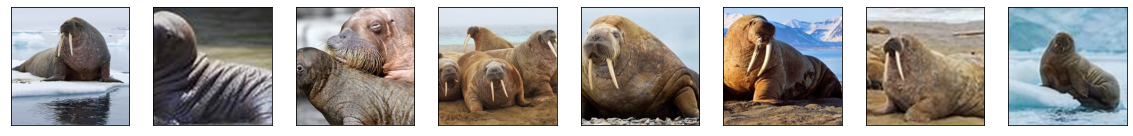

In [4]:
images, labels = load_images_from_path('Wildlife/train/walrus', 2)
show_images(images)
    
x_train += images
y_train += labels

Now load Arctic-fox test images and show the first few.

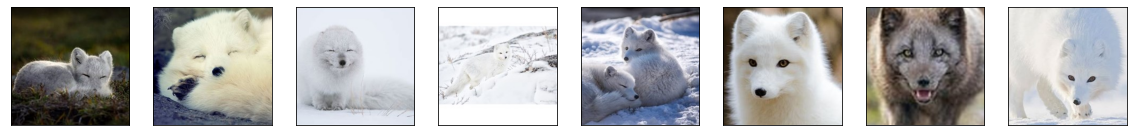

In [5]:
images, labels = load_images_from_path('Wildlife/test/arctic_fox', 0)
show_images(images)
    
x_test += images
y_test += labels

Load polar-bear test images.

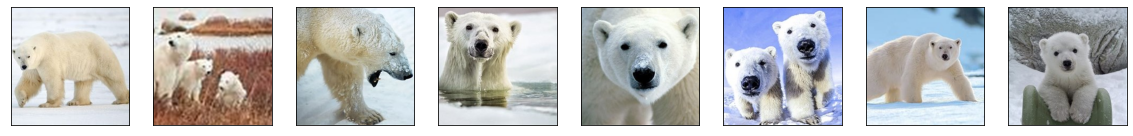

In [6]:
images, labels = load_images_from_path('Wildlife/test/polar_bear', 1)
show_images(images)
    
x_test += images
y_test += labels

Load walrus test images.

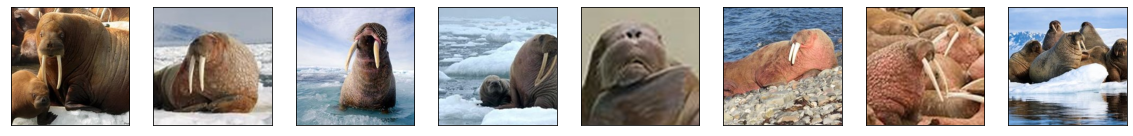

In [7]:
images, labels = load_images_from_path('Wildlife/test/walrus', 2)
show_images(images)
    
x_test += images
y_test += labels

Preprocess the training and testing images. The images must be preprocessed the same way the images used to train `ResNet50V` were preprocessed. This is accomplished by passing them to the `preprocess_input` function and dividing the resulting values by 255.

In [8]:
import numpy as np
from tensorflow.keras.applications.resnet50 import preprocess_input
 
x_train = preprocess_input(np.array(x_train)) / 255
x_test = preprocess_input(np.array(x_test)) / 255
     
y_train = np.array(y_train)
y_test = np.array(y_test)

## Train a classifier with the output from `ResNet50V2`

Rather than create a CNN of our own, we will load `ResNet50V2` without the classification layers and initialize it with the weights arrived at when it was trained on the [ImageNet](http://www.image-net.org/) dataset. We will then run our training and test images through it to extract features from them, and feed the features through our classifier.

In [9]:
from tensorflow.keras.applications import ResNet50V2
 
base_model = ResNet50V2(weights='imagenet', include_top=False)
 
x_train = base_model.predict(x_train)
x_test = base_model.predict(x_test)

4/4 [==============================] - 2s 548ms/step


Now define a simple network for doing classification and train it with the output from ResNet-50V2.

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
 
model = Sequential()
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
 
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=10, epochs=10)

Epoch 1/10
30/30 [==============================] - 7s 211ms/step - loss: 11.7198 - accuracy: 0.8767 - val_loss: 4.9287 - val_accuracy: 0.9500
Epoch 2/10
30/30 [==============================] - 6s 216ms/step - loss: 1.1042 - accuracy: 0.9833 - val_loss: 11.4502 - val_accuracy: 0.9500
Epoch 3/10
30/30 [==============================] - 7s 218ms/step - loss: 2.6751 - accuracy: 0.9800 - val_loss: 8.9515 - val_accuracy: 0.9583
Epoch 4/10
30/30 [==============================] - 6s 211ms/step - loss: 0.6193 - accuracy: 0.9967 - val_loss: 7.4685 - val_accuracy: 0.9667
Epoch 5/10
30/30 [==============================] - 6s 206ms/step - loss: 1.1664 - accuracy: 0.9933 - val_loss: 10.7135 - val_accuracy: 0.9417
Epoch 6/10
30/30 [==============================] - 6s 210ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 5.0689 - val_accuracy: 0.9667
Epoch 7/10
30/30 [==============================] - 6s 209ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 4.8272 - val_accuracy: 0.

How well did the network train? Let's plot the training accuracy and validation accuracy for each epoch.

[]

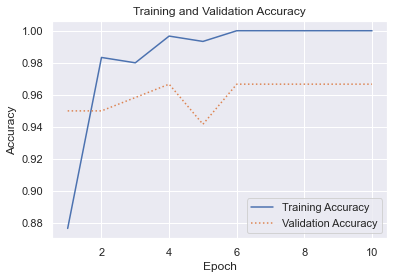

In [11]:
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

Use a confusion matrix to visualize how well the network performed during testing.

4/4 [==============================] - 0s 29ms/step


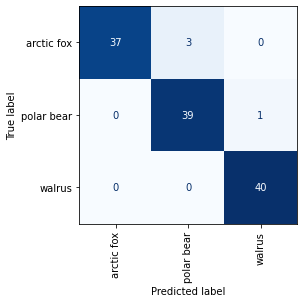

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd

sns.reset_orig()
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(False)

y_pred = model.predict(x_test)
class_labels = ['arctic fox', 'polar bear', 'walrus']

cmd.from_predictions(y_test, y_pred.argmax(axis=1),
                     display_labels=class_labels, colorbar=False,
                     cmap='Blues', xticks_rotation='vertical', ax=ax)

## Make a prediction

What happens if the network is used to classify an image that it hasn't seen before? And how do you go about making such a prediction? Let's take an Arctic fox image that the network was neither trained nor tested with and see how the network classifies it. The first step is to load the image.

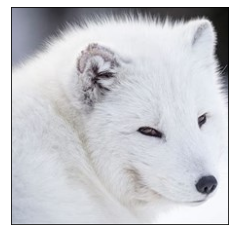

In [13]:
x = image.load_img('Wildlife/samples/arctic_fox/arctic_fox_140.jpeg', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Preprocess the image and run it through ResNet-50V2's feature-extraction layers, and then run the output through the newly trained classification layers.

In [14]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) / 255
 
y = base_model.predict(x)
predictions = model.predict(y)

1/1 [==============================] - 0s 36ms/step


The model predicts with a high degree of certainty that the image contains an example of class 0. Here's how the model scored the image for all three classes.

In [15]:
for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')

arctic fox: 1.0
polar bear: 0.0
walrus: 0.0


Now let's try it with a walrus image that the network hasn't seen before. Start by loading the image.

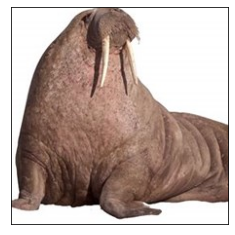

In [16]:
x = image.load_img('Wildlife/samples/walrus/walrus_143.png', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

Preprocess the image and make a prediction.

In [17]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x) / 255
 
y = base_model.predict(x)
predictions = model.predict(y)
 
for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')

1/1 [==============================] - 0s 34ms/step
arctic fox: 0.0
polar bear: 0.0
walrus: 1.0


`ResNet-50V2` wasn't trained to recognize walruses, but our network was.